<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [40]:
import tensorflow as tf

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [42]:
# Load the dataset
df = pd.read_csv('cleaned_train.csv')

In [43]:
# Select features and target variable
X = df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]
y = df['cluster_category']

In [44]:
# Encode categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [45]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [46]:
# Split data into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [47]:
# Gaussian noise to training data
noise_factor = 0.005
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

In [48]:
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

# Standardize before PCA
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X_train)

# Apply PCA
#pca = PCA(n_components=0.95)
#X_pca = pca.fit_transform(X_scaled)

#print(f"Original features: {X_train.shape[1]}, Reduced features: {X_pca.shape[1]}")

In [49]:
# Define Optimized Neural Network Model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(len(label_encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


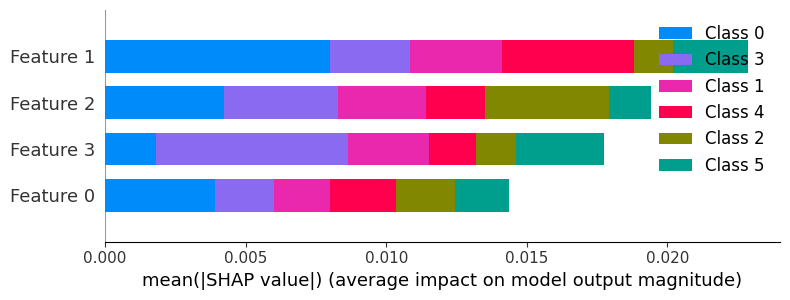

In [50]:
import shap

# SHAP Explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test[:100])

# Summary plot
shap.summary_plot(shap_values, X_test[:100])

In [51]:
# Compile the model
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [52]:
# Callbacks: Early Stopping & Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

In [53]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
classes = np.unique(y_train)

# Compute class weights
computed_weights = compute_class_weight('balanced', classes=classes, y=y_train)

# Convert to dictionary format (match class labels)
class_weight_dict = {int(classes[i]): computed_weights[i] for i in range(len(classes))}

#Dynamically boost the weight for Class 5 (index 4 in zero-based, but matches the class label)
class_5_label = 5
class_weight_dict[class_5_label] = max(class_weight_dict[class_5_label], max(computed_weights) * 0.2)

print("Updated Class Weights:", class_weight_dict)

Updated Class Weights: {0: np.float64(0.6839180240237852), 1: np.float64(0.8312513255852039), 2: np.float64(2.6352602730398664), 3: np.float64(0.7478467119787062), 4: np.float64(3.2657448132561253), 5: np.float64(0.7622064999581506)}


In [54]:
from imblearn.over_sampling import SMOTE

In [55]:
# Apply SMOTE to the training data
#smote = SMOTE(random_state=42)
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [56]:
# Train the model on the SMOTE-balanced data
#history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=64, validation_split=0.2,
#          callbacks=[early_stopping, lr_scheduler], class_weight=class_weight_dict)

In [57]:
history = model.fit(X_train_noisy, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler], class_weight=class_weight_dict)

Epoch 1/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.8382 - loss: 0.8440 - val_accuracy: 0.9599 - val_loss: 0.2418 - learning_rate: 3.0000e-04
Epoch 2/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9562 - loss: 0.3290 - val_accuracy: 0.9675 - val_loss: 0.1150 - learning_rate: 3.0000e-04
Epoch 3/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.9655 - loss: 0.2180 - val_accuracy: 0.9723 - val_loss: 0.0786 - learning_rate: 3.0000e-04
Epoch 4/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.9687 - loss: 0.1777 - val_accuracy: 0.9742 - val_loss: 0.0695 - learning_rate: 3.0000e-04
Epoch 5/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9717 - loss: 0.1577 - val_accuracy: 0.9732 - val_loss: 0.0635 - learning_rate: 3.0000e-04
Epoch 6/50
2419/2419 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9730 - loss: 0.1497 - val_accuracy: 0.9815 - val_loss: 0.0617 - learning_rate: 3.0000e-04
Epoch 7/50
2419/2419 ━━━━━━━━━━━━━━━━━━━

In [58]:
# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Train Loss: {loss:.4f}")
print(f"Train Accuracy: {accuracy:.4f}")

19352/19352 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9937 - loss: 0.0451
Train Loss: 0.0452
Train Accuracy: 0.9936


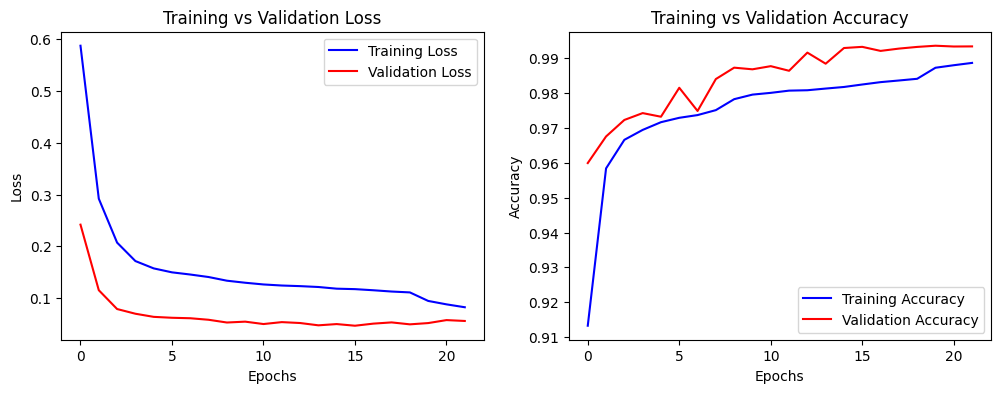

In [59]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [60]:
# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

4838/4838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


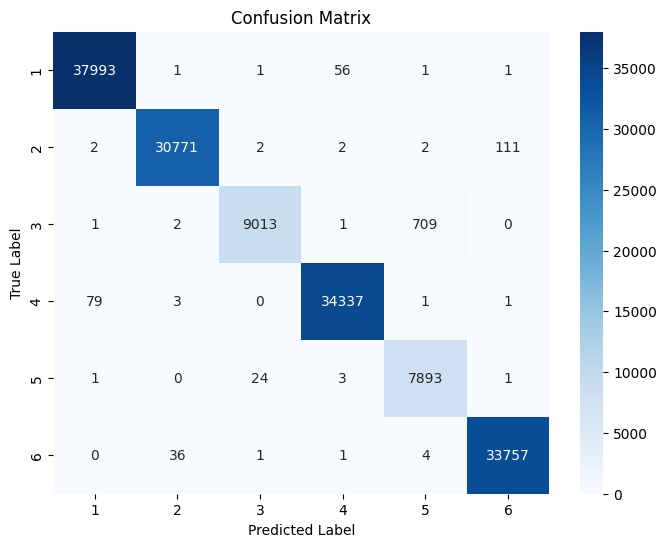

In [61]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [62]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     38053
           2       1.00      1.00      1.00     30890
           3       1.00      0.93      0.96      9726
           4       1.00      1.00      1.00     34421
           5       0.92      1.00      0.95      7922
           6       1.00      1.00      1.00     33799

    accuracy                           0.99    154811
   macro avg       0.98      0.99      0.98    154811
weighted avg       0.99      0.99      0.99    154811



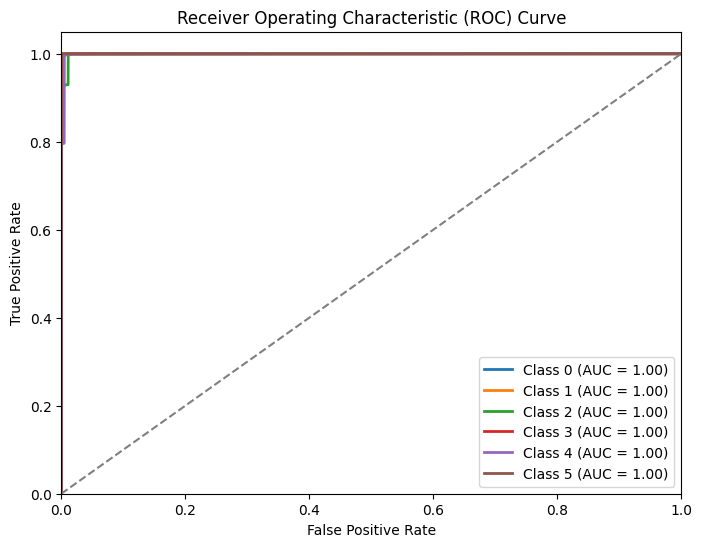

In [68]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Assuming `y_test` and `y_pred_prob` are already available
n_classes = y_pred_prob.shape[1]  # Number of classes from model output

# Binarize y_test if it's not already
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    if not np.isnan(roc_auc):  # Avoid plotting NaN values
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot chance level (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [64]:
# Load cleaned test dataset
cleaned_test = pd.read_csv('cleaned_test.csv')

In [65]:
# Select the same features used in training
X_cleaned_test = cleaned_test[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]

In [66]:
# Predict cluster categories
cleaned_test_predictions = model.predict(X_cleaned_test)
cleaned_test_predictions = np.argmax(cleaned_test_predictions, axis=1)

1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [67]:
# Save predictions
cleaned_test.to_csv('cleaned_test_predictions.csv', index=False)

print("Predictions saved successfully!")

Predictions saved successfully!
